## measuring latency of the memory Hierarchy
The purpose of this exercise is to test how fast different compture's can run the computationally intensive tasks. After the big computational task is complete, you create a summary file about how fast your comptuer ran. This summary file will be submitted in your homework for a grade.

With respect to this notebook, you just need to run each of the cells, almost no modifications required. 

Please Note: There are cells marked to be run by specific OS users. So, for those cells, run only the ones for the OS you are using. For example, if you are a windows OS user, then run only "Collecting System Description: For Windows  users ONLY" and not other cells.

## Import modules

In [1]:
# Enable automatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
from numpy import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
from matplotlib.backends.backend_pdf import PdfPages

from os.path import isfile,isdir
from os import mkdir
import os

In [3]:
import sys
sys.path.append('./lib')
from measureRandomAccess import measureRandomAccess
from PlotTime import PlotTime
from create_file import create_file,tee

## setting parameters
* We test access to arrays whose size is a multiple of 1MB. `n` is the block size.
* `m_list` defines the size of the arrays we test, in multiples of block-size.
* `k` defines the number of memory accesses.

In [4]:
n=1000000 # size of single block (1MB)
m_list=[1,10,100,1000] # size of file in blocks
k=100000;  # number of repeats
L=len(m_list)
print('n=%d, k=%d, m_list='%(n,k),m_list)

n=1000000, k=100000, m_list= [1, 10, 100, 1000]


## Set working directory
This script generates large files. We put these files in a separate directory so it is easier to delete them later.

In [5]:
log_root='./logs'
if not isdir(log_root): mkdir(log_root)
TimeStamp=str(int(time.time()))
log_dir=log_root+'/'+TimeStamp
mkdir(log_dir)
%cd $log_dir
stat=open('stats.txt','w')

def tee(line):
    print(line)
    stat.write(line+'\n')

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section1-Basics/0.MemoryLatency/logs/1519883246


In [6]:
_mean=zeros([2,L])   #0: using disk, 1: using memory
_std=zeros([2,L])
T=zeros([2,L,k])

In [7]:
Random_pokes=[]
for m_i in range(len(m_list)):
    
    m=m_list[m_i]
    (t_mem,t_disk) = create_file(n,m,filename='BlockData'+str(m))

    (_mean[0,m_i],_std[0,m_i],T[0,m_i]) = measureRandomAccess(n*m,filename='BlockData'+str(m),k=k)
    T[0,m_i]=sorted(T[0,m_i])
    tee('\rFile pokes _mean='+str(_mean[0,m_i])+', file _std='+str(_std[0,m_i]))

    (_mean[1,m_i],_std[1,m_i],T[1,m_i]) = measureRandomAccess(n*m,k=k)
    T[1,m_i]=sorted(T[1,m_i])
    tee('\rMemory pokes _mean='+str(_mean[1,m_i])+', Memory _std='+str(_std[1,m_i]))
    
    Random_pokes.append({'m_i':m_i,
                        'm':m,
                        'memory__mean': _mean[1,m_i],
                        'memory__std': _std[1,m_i],
                        'memory_largest': T[1,m_i][-1000:],
                        'file__mean': _mean[0,m_i],
                        'file__std': _std[0,m_i],
                        'file_largest': T[0,m_i][-1000:]                
                })

              
creating 1000000 byte block: 0.000564 sec, writing 1 blocks 0.006488 sec
File pokes _mean=2.28797888756e-05, file _std=6.04226524898e-05
Memory pokes _mean=1.22996807098e-06, Memory _std=2.8680485008e-06
              
creating 1000000 byte block: 0.000078 sec, writing 10 blocks 0.010494 sec
File pokes _mean=2.65381813049e-05, file _std=4.32161588592e-05
Memory pokes _mean=1.15330934525e-06, Memory _std=2.32146798613e-06
              
creating 1000000 byte block: 0.000035 sec, writing 100 blocks 0.094152 sec
File pokes _mean=4.43560481071e-05, file _std=0.000384287487378
Memory pokes _mean=1.36356830597e-06, Memory _std=2.89371196507e-06
              
creating 1000000 byte block: 0.000045 sec, writing 1000 blocks 0.956699 sec
File pokes _mean=0.00014021715641, file _std=0.00028255466285
Memory pokes _mean=1.79427623749e-06, Memory _std=3.00003754534e-06


1000 Memory Blocks of size 1000000 bytes
Memory pokes _mean=1.79427623749e-06, Memory _std=3.00003754534e-06


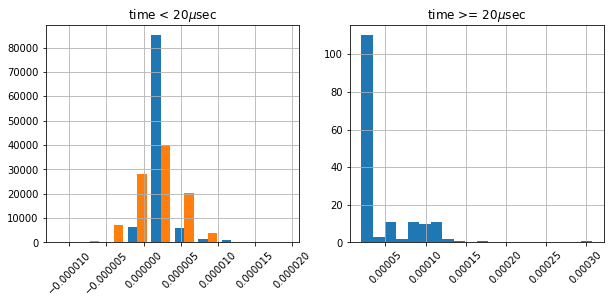

In [8]:
m_i=3
Disk_Mem=1
print('%d Memory Blocks of size %d bytes'%(m_list[m_i],n))
print('\rMemory pokes _mean='+str(_mean[1,m_i])+', Memory _std='+str(_std[1,m_i]))
_mean_t=_mean[Disk_Mem,m_i]
_std_t=_std[Disk_Mem,m_i]
_normal=random.normal(loc=_mean_t,scale=_std_t,size=T.shape[2])
tmp=T[Disk_Mem,m_i]
figure(figsize=(10,4))
subplot(121)
hist([tmp[tmp<0.00002],_normal],bins=10);
title('time < 20$\mu$sec')
xticks(rotation=45)
grid()
subplot(122)
hist(tmp[tmp>=0.00002],bins=20);
title('time >= 20$\mu$sec')
xticks(rotation=45);
grid();

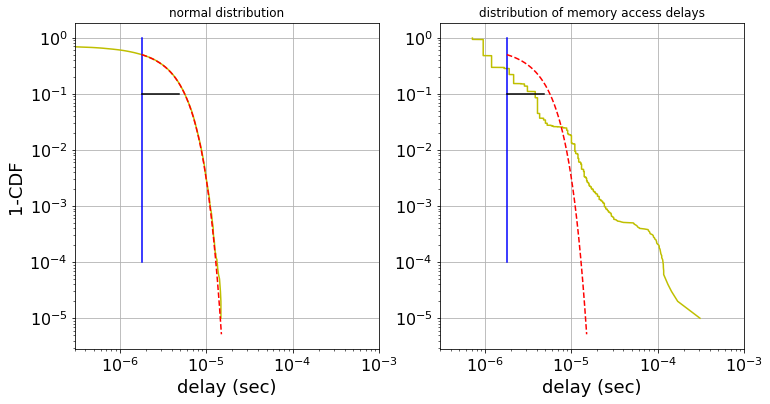

In [9]:
figure(figsize=(12,6))
subplot(121)
grid()
PlotTime(sort(_normal),_mean_t,_std_t,Color=['y','b','k','r'],LS=['-','-','-','--'])
title('normal distribution')
xlabel('delay (sec)',fontsize=18)
xlim([3e-7,1e-3])
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)

#print('%d Memory Blocks of size %d bytes'%(m_list[m_i],n))
#print('\rMemory pokes _mean='+str(_mean[1,m_i])+', Memory _std='+str(_std[1,m_i]))
subplot(122)
grid()
PlotTime(sort(tmp),_mean_t,_std_t,Color=['y','b','k','r'],LS=['-','-','-','--'])
title('distribution of memory access delays')
xlabel('delay (sec)',fontsize=18)
xlim([3e-7,1e-3])
#ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)

## Characterize random access to storage

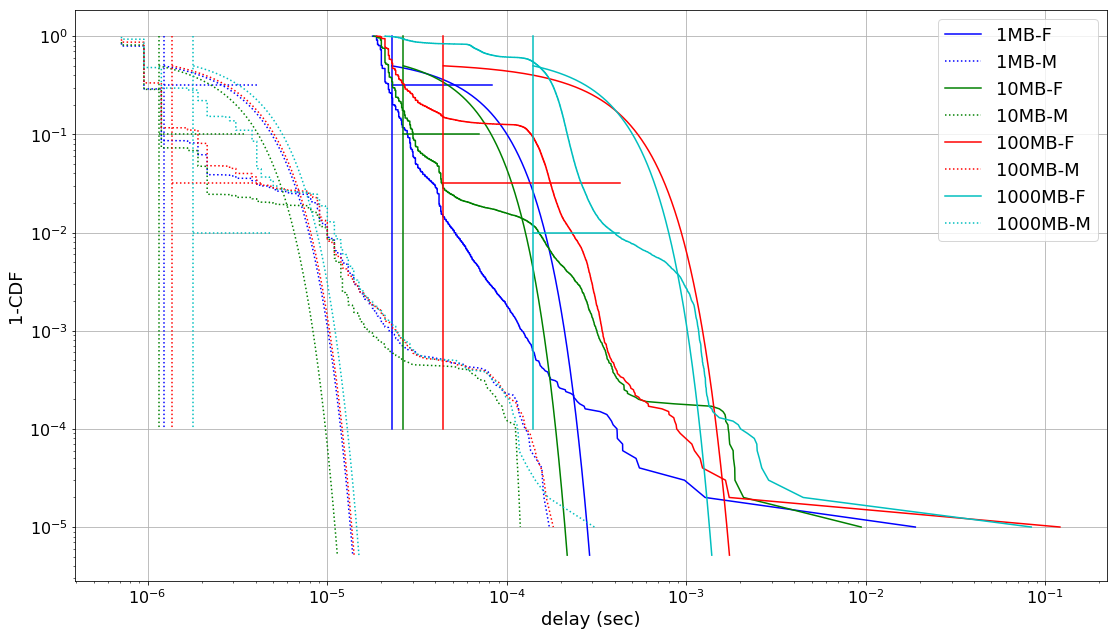

In [10]:
pp = PdfPages('MemoryFigure.pdf')
figure(figsize=(6,4))

Colors='bgrcmyk'  # The colors for the plot
LineStyles=['-',':']
Legends=['F','M']

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)

for m_i in range(len(m_list)):
    Color=Colors[m_i % len(Colors)]
    for Type in [0,1]:
        PlotTime(sort(T[Type,m_i]),_mean[Type,m_i],_std[Type,m_i],\
                 Color=Color,LS=LineStyles[Type],Legend=('%dMB-' % m_list[m_i])+Legends[Type],\
                 m_i=m_i)

grid()
legend(fontsize=18)
xlabel('delay (sec)',fontsize=18)
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)
pp.savefig()
pp.close()

## Characterize sequential access

In [11]:
import time
Consec=[]
Line='Consecutive Memory writes'
print(Line); stat.write(Line+'\n')
n=1000
r=np.array(list(range(n)))
for m in [1,3,5,7,10,100,1000,10000,100000,1000000]:
    t1=time.time()
    A=np.repeat(r,m)
    t2=time.time()
    Consec.append((n,m,float(n*m)/1000000,(t2-t1)/float(n*m)))
    tee("array of length %d repeated %d times. total size=%6.3f MB, Time per element= %g" % (n,m,float(n*m)/1000000,(t2-t1)/float(n*m)))
A=[];r=[]
stat.close()

Consecutive Memory writes
array of length 1000 repeated 1 times. total size= 0.001 MB, Time per element= 2.09808e-08
array of length 1000 repeated 3 times. total size= 0.003 MB, Time per element= 6.67572e-09
array of length 1000 repeated 5 times. total size= 0.005 MB, Time per element= 4.3869e-09
array of length 1000 repeated 7 times. total size= 0.007 MB, Time per element= 3.54222e-09
array of length 1000 repeated 10 times. total size= 0.010 MB, Time per element= 1.1611e-08
array of length 1000 repeated 100 times. total size= 0.100 MB, Time per element= 3.00884e-09
array of length 1000 repeated 1000 times. total size= 1.000 MB, Time per element= 4.23813e-09
array of length 1000 repeated 10000 times. total size=10.000 MB, Time per element= 7.59637e-09
array of length 1000 repeated 100000 times. total size=100.000 MB, Time per element= 7.9401e-09
array of length 1000 repeated 1000000 times. total size=1000.000 MB, Time per element= 9.3007e-09


## Observations

* If you write to consecutive locations, you have a per-byte time of around $10^{-8}$ if you jump around you can't do better than $10^{-6}$.
* As you increase the size of the array/file random access speed decreases dramatically, while sequential access speed stays more or less constant.
* The high latency tails are much bigger than what you'd expect from a normal distribution with the same mean and std.

## Impact on Big Data Analytics
* Clock rate is stuck at around 3GHz, and is likely to be stuck there for the forseeable future.
* **Faster** computers / disks / networks are **expensive** 
* The cost-effective solution is often a cluster of many cheap computers, each with many cores and break up the data so that each computer has a small fraction of the data.
* Data-Centers and the "Cloud"

## Logging our results
So that they can be compared to those of others.

In [12]:
isVM = ["False"]

### Uncomment and Run the following code ONLY if you are running a Virtual Machine

In [13]:
#isVM = ["True"]

### Collecting System Description: For Mac users ONLY

The next cell needs to be run only by Mac OS users. If run on other OS platforms, it will throw error. 

In [14]:
brand_name = ["brand: Macbook"]
os_info = !sysctl kernel.osrelease kernel.osrevision kernel.ostype kernel.osversion
cpu_info = !sysctl machdep.cpu.brand_string machdep.cpu.cache.L2_associativity machdep.cpu.cache.linesize machdep.cpu.cache.size machdep.cpu.core_count
cache_info = !sysctl kern.procname hw.memsize hw.cpufamily hw.activecpu hw.cachelinesize hw.cpufrequency hw.l1dcachesize hw.l1icachesize hw.l2cachesize hw.l3cachesize hw.cputype 

### Collecting System Description:  For Linux OS users ONLY

The next cell needs to be run only by Linux OS users. If run on other OS platforms, it will throw error.

In [15]:
brand_name = ["brand: Linux"]

os_info = !sysctl kernel.ostype kernel.osrelease 
os_version = !lsb_release -r
memory_size = !cat /proc/meminfo | grep 'MemTotal'
os_info += os_version + memory_size

cache_L1i = !lscpu | grep 'L1i'
cache_L1d = !lscpu | grep 'L1d'
cache_L2 = !lscpu | grep 'L2'
cache_L3 = !lscpu | grep 'L3'
cache_info = cache_L1i + cache_L1d + cache_L2 + cache_L3

cpu_type = !lscpu | grep 'CPU family'
cpu_brand = !cat /proc/cpuinfo | grep -m 1 'model name'
cpu_frequency = !lscpu | grep 'CPU MHz'
cpu_core_count = !lscpu | grep 'CPU(s)'
cpu_info = cpu_type + cpu_brand + cpu_frequency + cpu_core_count



###  Collecting System Description: For Windows users ONLY 
The next cell needs to be run only by Windows OS users. If run on other OS platforms, it will throw error.

In [16]:
brand_name = ["brand: Windows"]

os_release  = !ver
os_type     = !WMIC CPU get  SystemCreationClassName
memory      = !WMIC ComputerSystem get TotalPhysicalMemory
os_info     = os_release + os_type

cpu_core_count  = !WMIC CPU get NumberOfCores
cpu_speed       = !WMIC CPU get CurrentClockSpeed
cpu_model_name  = !WMIC CPU get name
cpu_info        = cpu_core_count + cpu_speed + cpu_model_name

l2cachesize = !WMIC CPU get L2CacheSize
l3cachesize = !WMIC CPU get L3CacheSize
cache_info  = l2cachesize + l3cachesize


In [17]:
description= isVM + brand_name + os_info + cache_info + cpu_info
description

['False',
 'brand: Windows',
 '/bin/bash: ver: command not found',
 '/bin/bash: WMIC: command not found',
 '/bin/bash: WMIC: command not found',
 '/bin/bash: WMIC: command not found',
 '/bin/bash: WMIC: command not found',
 '/bin/bash: WMIC: command not found',
 '/bin/bash: WMIC: command not found']

### memory and cache sizes for Macbook Pro

| type of memory  | size (bytes) | approx size |
| --------------: | ---: | ----------: |
| hw.l1dcachesize: | 32,768 | 32KB |     
| hw.l1icachesize: | 32,768 | 32KB |
| hw.l2cachesize: | 262,144 | 262KB |
| hw.l3cachesize: | 6,291,456 | 6MB |
| hw.memsize:     | 17,179,869,184 | 17GB |
| Solid-state-disk: |  1,099,511,627,776 | 1TB |


In [18]:
# Writing all necesarry information int oa pickle file.
import pickle
with open('memory_report.pkl','wb') as pickle_file:
    pickle.dump({'description':description,
                'Consec':Consec,
                'Random_pokes':Random_pokes},
               pickle_file)

## Important:
Make sure to delete the logs directory! The commands that you ran above made the log directory very big, you WILL NOT be submitting the log directory.